In [2]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [3]:
import gensim
import pandas as pd
import numpy as np

from multiprocessing import cpu_count
import p9_util

workers = cpu_count()

is_w2vec_saved = False
extension=''

Using TensorFlow backend.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def build_dict_tfidf(X):
    '''
    Build a dictionary {token:tfidf} of all tokens issued from W2VEC.
    A TF-IDF vectorizer is built from list of sentences issued from X.
        Input : 
            * X : list of tokens
        Output : 
            * tfidf_vectorizer, dict_tfidf
    '''
    tfidf_vectorizer = TfidfVectorizer()
    X_sentence = [" ".join(X[raw]) for raw in range(0, len(X))]
    X_tidf = tfidf_vectorizer.fit_transform(X_sentence)
    # Normalization
    ser_tfidf = pd.Series(tfidf_vectorizer.vocabulary_)
    ser_sum = ser_tfidf.sum()
    ser_tfidf = ser_tfidf/ser_sum
    dict_tfidf = ser_tfidf.to_dict()
    return tfidf_vectorizer, dict_tfidf

In [ ]:
import numpy as np
def build_weight_matrix(w2vec, dict_tfidf=None):
    dim = w2vec.wv.vectors.view().shape[1]
    word_matrix = np.zeros(dim)
    zero_vector = np.zeros(dim)

        
    #--------------------------------------------------------------------------
    # dict_tfidf is intialized if None.
    #--------------------------------------------------------------------------
    if dict_tfidf is None :
        dict_tfidf = dict()
        for word in w2vec.wv.vocab :
            dict_tfidf[word] = 1.
    
    #--------------------------------------------------------------------------
    # Words from that are not in vocabulary are replaced with a zero vector.
    # Empty text, mean `list_corpus[i]` is empty is replaced with a zero vector.
    #--------------------------------------------------------------------------
    list_unique_word = list()
    index = 0
    for word, tfidf in dict_tfidf.items() :
        if word in w2vec.wv.vocab : 
            if word in list_unique_word:
                pass
            else:
                word_vector = np.mean( [ w2vec.wv[word]*tfidf ], axis=0 )
                list_unique_word.append(word)
        else :
            word_vector = zero_vector
        #---------------------------------------------------------------------------------------
        # Check empty text (empty list of words) and replace it with ezro vector, when required
        #---------------------------------------------------------------------------------------
        if 0 == len(word_vector.shape) :
            print(index)
            word_vector = zero_vector
        else :
            pass
        #---------------------------------------------------------------------------------------
        # Matrix of corpus is computed.
        # Each raw is a text from corpus while each column is a feature of the corpus.
        #---------------------------------------------------------------------------------------
        word_matrix = np.vstack((word_matrix,word_vector))
        index +=1
    #--------------------------------------------------------
    # Remove first raw from matrix
    #--------------------------------------------------------
    word_matrix = word_matrix[1:]
    print("\n Number of unique words from W2EVC vocabulary = {}".format(len(list_unique_word)))
    return word_matrix

In [ ]:
def get_sample(X, y, ratio=-1) :
    range_value = int(len(X)*ratio)
    return X[:range_value], y[:range_value]

In [ ]:
class MeanW2VecEmbedding():
    def __init__(self, w2vec) :
        self._w2vec = w2vec
        
    def fit(self, X, y):
        
        return self
    
    def transform(self,X,y):
        range_index = range(0, len(X),1)
        list_X_y = [ (gensim.utils.simple_preprocess(X[index], deacc=False, min_len=2), y[index]) for index in range_index]
        list_X = [list_X_y[i][0] for i in range(0, len(list_X_y),1)]
        list_y = [list_X_y[i][1] for i in range(0, len(list_X_y),1)]
        list_X, list_y = p9_util.clean_X_label(list_X, list_y)
        X = build_word_matrix(self._w2vec, list_X)
        return X, np.array(list_y)
    

# <font color=blue>1. Data are read from files and pre-processed</blue>

All text is lowered.

## <font color=blue>1.1 Dataset sampling</blue>

In [ ]:
df_test = pd.read_csv('./data/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())

#### Average and standard deviation for text length

In [ ]:
# Get the average length of a text
avg = sum(map(len, df_train['comment_text'])) / len(df_train['comment_text'])

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, df_train['comment_text'])) / len(df_train['comment_text']))

avg,std

In [ ]:
print(max(map(len, df_train['comment_text'])), min(map(len, df_train['comment_text'])))
maxlen = int(avg+std)
maxlen

#### Data is splitted into Train and Test datasets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train['comment_text'],df_train['target'],test_size=0.33, random_state=42)

print("Train dataset: X = {} Label= {}".format(X_train.shape, y_train.shape))
print("Test dataset: X = {} Label= {}".format(X_test.shape, y_test.shape))

#### For testing models, a ratio of train and test datasets are used.

When value is -1, then the whole dataset is used.

In [ ]:
ratio=0.3

X_train, y_train  = get_sample(X_train, y_train, ratio=ratio)
X_train.shape, y_train.shape

#### Same ratio is used for test dataset.

In [ ]:
X_test, y_test  = get_sample(X_test, y_test, ratio=ratio)
X_test.shape, y_test.shape

## <font color=blue>1.2 Corpus pre-processing</font>
All texts from corpus are tokenized.

Too short tokens (< 2 characters) and too long tokens (> 15 characters) are ignored.

`list_train_corpus_label` is a list of tuples. Each one of the tuple from this list is a text from the corpus.
* 1st tuple component is a list of tokens issued from pre-processing
* 2nd tuple component is the text label value.

In [ ]:
list_train_corpus_label = [ (gensim.utils.simple_preprocess(X_train[index], deacc=True, min_len=2), y_train[index]) for index in X_train.index]

Here-under, first element from list of tuples contains 164 tokens, while second element contains 24 tokens.

In [ ]:
print(list_train_corpus_label[1][0])
len(list_train_corpus_label[0][0]),len(list_train_corpus_label[1][0])

From previous `list_train_corpus_label`, X and label are extracted, leading to `X_train` and `y_train`.

In [ ]:
X_train = [list_train_corpus_label[i][0] for i in range(0, len(list_train_corpus_label),1)]
y_train = [list_train_corpus_label[i][1] for i in range(0, len(list_train_corpus_label),1)]

#### Build a corpus sample from test dataset

In [ ]:
list_test_corpus_label = [ (gensim.utils.simple_preprocess(X_test[index], deacc=False, min_len=2), y_test[index]) for index in X_test.index]

X_test = [list_test_corpus_label[i][0] for i in range(0, len(list_test_corpus_label),1)]
y_test = [list_test_corpus_label[i][1] for i in range(0, len(list_test_corpus_label),1)]

#### Corpus is cleaned.

Some text are empty, due to previous pre-processing. They are then removed.
Corresponding y value are also removed, based on indexes values.

`X_train` and `X_test` are lists of items, while each item is a list of tokens.

In [ ]:
import p9_util
X_train, y_train = p9_util.clean_X_label(X_train, y_train)

In [ ]:
import p9_util

X_test, y_test = p9_util.clean_X_label(X_test, y_test)

## <font color=blue>1.3 Processing Stop Words</font>

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
X_train = [[remove_stopwords(word) for word in list_word if len(remove_stopwords(word))>0] for list_word in X_train]

In [ ]:
X_test = [[remove_stopwords(word) for word in list_word if len(remove_stopwords(word))>0] for list_word in X_test]

## <font color=blue>1.4 Read pre-processed data from file</font>

In [ ]:
import p5_util


if True :
    filename = './data/X_train'+extension+'.dump'
    X_train = p5_util.object_load(filename)


    filename = './data/X_test'+extension+'.dump'
    X_test = p5_util.object_load(filename)

    filename = './data/y_train'+extension+'.dump'
    y_train = p5_util.object_load(filename)


    filename = './data/y_test'+extension+'.dump'
    y_test = p5_util.object_load(filename)
else :
    filename = './data/X_train'+extension+'.dump'
    p5_util.object_dump(X_train, filename)

    filename = './data/X_test'+extension+'.dump'
    p5_util.object_dump(X_test, filename)

    filename = './data/y_train'+extension+'.dump'
    p5_util.object_dump(y_train, filename)

    filename = './data/y_test'+extension+'.dump'
    p5_util.object_dump(y_test, filename)
    

print("\nTrain dataset size: X={} / y={}".format(len(X_train), len(y_train)))
print("Test dataset size:  X={} / y={}".format(len(X_test), len(y_test)))

    All tokenized texts from corpus are filetered.
    Filtering avoid texts with more then max_length tokens.
    max_length has been fixed after the analysis conducted in BOW-Jigsaw.ipynb notebook.

In [ ]:
import p9_util
max_length = 37

X_train_filtered, y_train_filtered = p9_util.X_y_filter_max_length(X_train, y_train, max_length)
X_test_filtered, y_test_filtered = p9_util.X_y_filter_max_length(X_test, y_test, max_length)

print("\nTrain dataset filtered size: X={} / y={}".format(len(X_train_filtered), len(y_train_filtered)))
print("Test dataset filtred size:   X={} / y={}".format(len(X_test_filtered), len(y_test_filtered)))

In [6]:
import p5_util

if True :
    #---------------------------------------------------------
    # Filtered Dataset is reloaded
    #---------------------------------------------------------
    filename = './data/X_train_filtered'+extension+'.dump'
    X_train_filtered = p5_util.object_load(filename)


    filename = './data/X_test_filtered'+extension+'.dump'
    X_test_filtered = p5_util.object_load(filename)

    filename = './data/y_train_filtered'+extension+'.dump'
    y_train_filtered = p5_util.object_load(filename)


    filename = './data/y_test_filtered'+extension+'.dump'
    y_test_filtered = p5_util.object_load(filename)
else :
    #---------------------------------------------------------
    # Filtered Dataset is dumped into files
    #---------------------------------------------------------
    filename = './data/X_train_filtered'+extension+'.dump'
    p5_util.object_dump(X_train_filtered, filename)


    filename = './data/X_test_filtered'+extension+'.dump'
    p5_util.object_dump(X_test_filtered, filename)

    filename = './data/y_train_filtered'+extension+'.dump'
    p5_util.object_dump(y_train_filtered, filename)


    filename = './data/y_test_filtered'+extension+'.dump'
    p5_util.object_dump(y_test_filtered, filename)
    

print("\nTrain filtered dataset size: X={} / y={}".format(len(X_train_filtered), len(y_train_filtered)))
print("Test filtered dataset size:  X={} / y={}".format(len(X_test_filtered), len(y_test_filtered)))

p5_util.object_load : fileName= ./data/X_train_filtered.dump
p5_util.object_load : fileName= ./data/X_test_filtered.dump
p5_util.object_load : fileName= ./data/y_train_filtered.dump
p5_util.object_load : fileName= ./data/y_test_filtered.dump

Train filtered dataset size: X=286881 / y=286881
Test filtered dataset size:  X=141204 / y=141204


## <font color=blue>BOW</font>

In [7]:
import p9_util

max_length=37

#-----------------------------------------------
# Tokenizer is built and returned from function
#-----------------------------------------------
X_train_bow, tokenizer = p9_util.bow_matrix_build(X_train_filtered, max_length)
print(len(X_train_bow))

#-----------------------------------------------
# Tokenizer is used inside function
#-----------------------------------------------
X_test_bow, _ = p9_util.bow_matrix_build(X_test_filtered, max_length, tokenizer=tokenizer)
print(len(X_test_bow))

286881
141204


In [ ]:
print(len(y_train_filtered))
print(len(y_test_filtered))

In [16]:
import p5_util
y_train_bow = y_train_filtered.copy()
y_test_bow  = y_test_filtered.copy()
if False :
    #---------------------------------------------------------
    # BOW Dataset is reloaded
    #---------------------------------------------------------
    filename = './data/X_train_bow'+extension+'.dump'
    X_train_bow = p5_util.object_load(filename)


    filename = './data/X_test_bow'+extension+'.dump'
    X_test_bow = p5_util.object_load(filename)

    filename = './data/y_train_bow'+extension+'.dump'
    y_train_bow = p5_util.object_load(filename)

    filename = './data/y_test_bow'+extension+'.dump'
    y_test_bow = p5_util.object_load(filename)

    filename = './data/tokenizer'+extension+'.dump'
    tokenizer = p5_util.object_load(filename)
    
else :
    #---------------------------------------------------------
    # BOW Dataset is dumped into files
    #---------------------------------------------------------
    filename = './data/X_train_bow'+extension+'.dump'
    p5_util.object_dump(X_train_bow, filename)

    filename = './data/X_test_bow'+extension+'.dump'
    p5_util.object_dump(X_test_bow, filename)

    filename = './data/y_train_bow'+extension+'.dump'
    p5_util.object_dump(y_train_bow, filename)


    filename = './data/y_test_bow'+extension+'.dump'
    p5_util.object_dump(y_test_bow, filename)

    filename = './data/tokenizer'+extension+'.dump'
    p5_util.object_dump(tokenizer, filename)


print("\nTrain BOW dataset size: X={} / y={}".format(len(X_train_bow), len(y_train_bow)))
print("Test BOW dataset size:  X={} / y={}".format(len(X_test_bow), len(y_test_bow)))


Train BOW dataset size: X=286881 / y=286881
Test BOW dataset size:  X=141204 / y=141204


# <font color=blue>2. Corpus Bag of Word using TF-IDF vectorization</font>

Corpus is rebuilt from pre-processed list of tokens issued from `gensim.utils.simple_preprocess`

This allows to compute TF-IDF vectors with the same set of tokens then the one built from `W2VEC`.

TF-IDF values are normalized in order to weight text vectors computed from `W2VEC` words vectors.

This leads having a dictionary `dict_tfidf = {token:tfidf}`.

Applying `tfidf_vectorizer.transform(text)` leads to a resulting sparse matrix. This is due to the fact
TF-IDF vocabulary is very large.

TF-IDF Vocabulary size is given with `len(tfidf_vectorizer.vocabulary_)`. TF-IDF vocabulary size is also `len(dict_tfidf)`.


In [ ]:
tfidf_vectorizer, dict_tfidf = build_dict_tfidf(X_train)

In [ ]:
print("TF-IDF vocabulary size= {}".format(len(tfidf_vectorizer.vocabulary_)))
print("Number of unique tokens in corpus= {}\n".format(len(dict_tfidf)))

# <font color=blue>3. Word embeddings with W2VEC</font>

With `W2VEC`, a vector space is defined from corpus and coordonates of a word is defined in this vector space.
Such coordonates are named embeddings.

Those coordonates, that are learned from text, depends of the surround words. Surrounds words define a semantic context. 

Then coordonates of a word reflects semantics relations with other words.

Each word will be vectorized as a vector of dimension = `embeddings_dim`.

`embeddings_dim` is fixed considering Glove embeddings used in this project. It is 100.

`X_train` is a list of lists in which : 
* Each element of list is a text from the corpus
* Each text from corpus is represented as a list of tokens

Vector space is built with `W2VEC` from `X_train`.

In [4]:
import p9_util

# When False, then W2VEC model is built and dumped.
is_saved = True

# Dimension of the vector space is fixed in embeddings_dim
embeddings_dim=100

# Number of step for each word from corpus to learn its coordonates
epochs=10

# W2VEC Model saved into a file.
model_filename_to_save = './data/model_w2vec_'+str(epochs)+'_epochs'+extension+'.h5'

# W2VEC Model is returned
if is_saved is True :
    w2vec = p9_util.get_trained_w2vec(model_filename_to_save, None, epochs, embeddings_dim=embeddings_dim, is_saved=is_saved)
else :
    w2vec = p9_util.get_trained_w2vec(model_filename_to_save, X_train_filtered, epochs, embeddings_dim=embeddings_dim, is_saved=False)


True True
Loading W2VEC model...
Done!



In [ ]:
print(w2vec.corpus_count)
print(w2vec.get_latest_training_loss())

### <font color=blue>3.1. X_train is transformed into an Embeddings matrix thanks to W2VEC</font>

In W2VEC, each word is represented as a vector. 

In this context, a text composed from tokens may be represented 
as a linear combination of vectors of words.

By default, W2VEC model is build as Countinuous Bag of Word (CBOW). This means that by default, the model will be able to predict a word from a given context.


The result is a (NxM) matrix with : 
 * N raws : number of sentences into the corpus.
 * M columns : dimension of W2VEC vectorial space.

Number of columns, means embeddings dimension, is provided with attribute `w2vec.wv.vector_size`

Vocabulary size is provided with `len(w2vec.wv.vocab)`

In [ ]:
import p9_util

train_w2vec_matrix, list_index_excluded = p9_util.build_corpus_matrix(w2vec,X_train_filtered)

#Corpus matrix is dumped into a file
print("\nCorpus Shape= {} / excluded indexes={}".format(train_w2vec_matrix.shape, len(list_index_excluded)))

In [ ]:
import p5_util
filename = './data/w2vec_train_corpus_matrix'+extension+'.dump'
p5_util.object_dump(train_w2vec_matrix, filename)

In [ ]:
train_w2vec_matrix.shape

#### Indentification of sentences that do not fit into corpus embeddings matrix.

This allows to keep matching `y_train_filtered` indexes with `train_w2vec_matrix`

In [ ]:
len(X_train_filtered) - train_w2vec_matrix.shape[0]

In [ ]:
import p9_util
dict_train_index_excluded = p9_util.get_excluded_dict_index_list(X_train_filtered, w2vec)

Some tokenized sentences are excluded from corpus matrix. Followings display 10 of these excluded indexes.

In [ ]:
print("\nNumber of excluded sentences from embeddings matrix= {}".format(len(dict_train_index_excluded)))
dict_train_index_excluded

Most of the excluded words above are due words obfuscation, such as `dmonish`, `phuckerberg`.

Such words have a phonetic semantic.

Others are due to orthographic fails, such as : `euthanization`, `twoo`

Some are due to inappropriate character adds : `s_cold`, `they_didn`


#### Targets values from `y_train_filtered` out of embeddings matrix raws are removed  

In [ ]:
import numpy as np

y_train_filtered = [y_train_filtered[index] for index in range(0, len(y_train_filtered)) if index not in dict_train_index_excluded.keys()]

print("\ny_train_filtered length after removing sentences out of embedding matrix: {}".format(len(y_train_filtered)))

filename = './data/y_train_filtered'+extension+'.dump'
p5_util.object_dump(np.array(y_train_filtered), filename)

### <font color=blue>3.2. X_test is transformed into an Embeddings matrix using W2VEC</font>

    Note that text length is not restricted for test dataset.
    W2VEC model built from train dataset is used for test dataset.

In [ ]:
import p5_util
import p9_util

test_w2vec_matrix, list_index_excluded = p9_util.build_corpus_matrix(w2vec,X_test_filtered)

filename = './data/w2vec_test_corpus_matrix'+extension+'.dump'
p5_util.object_dump(test_w2vec_matrix, filename)

In [ ]:
print("Embeddings for test data Shape= {}".format(test_w2vec_matrix.shape))

In [ ]:
import p9_util
dict_test_index_excluded = p9_util.get_excluded_dict_index_list(X_test_filtered, w2vec)
print("Indexes excluded from test embeddings= {}".format(len(dict_test_index_excluded)))


In [ ]:
y_test_filtered = [y_test[index] for index in range(0, len(y_test_filtered)) if index not in dict_test_index_excluded.keys()]

print("\ny_test_filtered length after removing sentences out of embedding matrix: {}".format(len(y_test_filtered)))

filename = './data/y_test_filtered'+extension+'.dump'
p5_util.object_dump(np.array(y_test_filtered), filename)

In [ ]:
for index in dict_test_index_excluded.keys() : 
    print(X_test_filtered[index])

# <font color=blue>4. Applying estimators</font>

In [ ]:
extension

In [ ]:
import p5_util

filename = './data/w2vec_train_corpus_matrix'+extension+'.dump'
train_w2vec_matrix = p5_util.object_load(filename)

filename = './data/w2vec_test_corpus_matrix'+extension+'.dump'
test_w2vec_matrix = p5_util.object_load(filename)

print("\nTrain matrix shape : {}".format(train_w2vec_matrix.shape))
print("Test matrix shape :  {}".format(test_w2vec_matrix.shape))
print()
filename = './data/y_train_filtered'+extension+'.dump'
y_train_filtered = p5_util.object_load(filename)

filename = './data/y_test_filtered'+extension+'.dump'
y_test_filtered = p5_util.object_load(filename)
print(len(y_train_filtered))
print(len(y_test_filtered))

## <font color=blue>4.1 Linear regression</font>

In [ ]:
print(train_w2vec_matrix.shape, len(y_train_filtered))
print(test_w2vec_matrix.shape, len(y_test_filtered))

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_bow, y_train_bow)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
y_predict = lr.predict(X_test_bow)

In [21]:
from sklearn.metrics import r2_score
r2_score(y_test_bow, y_predict)

0.0003921699099286302

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_bow, y_predict))
print("RMSE for Linear Regression: %.4f" % rmse**2)
print("MSE for Linear Regression:  %.4f" % rmse)

RMSE for Linear Regression: 0.0408
MSE for Linear Regression:  0.2019


## <font color=blue>4.2 XgBoost</font>

In [23]:
import xgboost as xgb
from multiprocessing import cpu_count
import p9_util

workers = cpu_count()


xgbr = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.001,
                max_depth = 10, reg_lambda = 0., n_estimators = 100, n_jobs=workers,verbosity=1)

In [ ]:
print(train_w2vec_matrix.shape, len(y_train_filtered))
print(test_w2vec_matrix.shape, len(y_test_filtered))

In [24]:
np.array(y_train_bow).min(),np.array(y_train_bow).max()

(0.0, 1.0)

    Training XGBOOST

In [25]:
xgbr.fit(X_train_bow, y_train_bow)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.001, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0.0, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

    Applying predictions with trained XGBOOST

In [26]:
y_preds = xgbr.predict(X_test_bow)

    NAN values issued from prediction are removed, if any.

In [ ]:
arr_nan_index = np.argwhere(np.isnan(y_preds)).flatten()
print(arr_nan_index)

print()    

In [ ]:
y_test_filtered_ = np.delete(y_test_bow,(arr_nan_index), axis=0)
y_preds_ = np.delete(y_preds,(arr_nan_index), axis=0)
test_w2vec_matrix_ = np.delete(test_w2vec_matrix, (arr_nan_index), axis=0)

print(len(y_test_filtered),len(y_test_filtered_),test_w2vec_matrix_.shape )

    Evaluation of performance.

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error
if True :
    rmse = np.sqrt(mean_squared_error(y_preds,y_test_bow))
    print("RMSE: %f" % (rmse))
print("R2 score= %f" % (xgbr.score(X_test_bow, y_preds)))

RMSE: 0.410943
R2 score= 1.000000


In [28]:
print(y_preds[:10])
print()
print(y_test_bow[:10])

[0.4629034  0.4627312  0.4663887  0.46237525 0.46230155 0.46019953
 0.46281195 0.46216503 0.4607942  0.46168455]

[0.16666666666666666, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 0.0]


## <font color=blue>4.3 CNN estimator</font>

First hidden layer is created using `keras.layers.Embedding`

<br>
Words need to be encoded as integers. This process is achieved with text tokenization. Texts are issued from corpus.

Arguments are followings: 
* `vocab_size` : size of the vocabulary. This size is issued from TF-IDF vectorization.
* `embedding_dim` : dimension of vectorized words.
* `input_length` : number of words in a text feeding the model
* `weights` : when provided, this is corpus weight matrix sized as (vocab_size * embedding_dim)

In [5]:
from gensim.models import Word2Vec
w2vec = Word2Vec.load(model_filename_to_save)

#### Build W2VEC embeddings

In [11]:
import p9_util
w2vec_embeddings_matrix, vocab = p9_util.w2vec_embeddings_build(w2vec, tokenizer=tokenizer)
print("W2VEC Embedding matrix = {}".format(w2vec_embeddings_matrix.shape))

W2VEC Embedding matrix = (94168, 100)


In [12]:
vocab_size = len(vocab)+1
print("Vocabulary size= {}".format(vocab_size))

Vocabulary size= 94168


In [40]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout, Embedding, Input
from keras.layers.normalization import BatchNormalization


# Each text input will be vecorized as embedding_dim dimensions.
model = Sequential()

#----------------------------------------------------------------
# Convolutional layers
#----------------------------------------------------------------
if True :
    embedding_dim = w2vec.vector_size

    # input_length = length of the text given as input
    # vocab_size : number of unique words used in order to encode the corpus.
    # embedding_dim : size of the output dense layer;
    # weights
    #model.add(Input(shape=(max_length,), dtype='int32'))
    model.add(Embedding(vocab_size, 
                        embedding_dim,
                        input_length=max_length, 
                        weights = [w2vec_embeddings_matrix], 
                        trainable = False))


else : 
    model.add(Conv1D(32, 3,padding='same', activation='relu', strides=2, input_shape=(100,1)))

model.add(BatchNormalization())
model.add(Conv1D(32, 3,padding='same', strides=2, activation='relu'))
#model.add(MaxPooling1D(3))

model.add(BatchNormalization())
model.add(Conv1D(32, 3,padding='same', strides=2, activation='relu'))

model.add(BatchNormalization())
model.add(Conv1D(16, 5,padding='same', strides=4, activation='relu'))

#model.add(BatchNormalization())
#model.add(Conv1D(8, 7,padding='same', strides=6, activation='relu'))

#----------------------------------------------------------------
# Dense layers
#----------------------------------------------------------------
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(48, activation='relu'))


model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(24, activation='relu'))


model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(12, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(6, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(3, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(2, activation='relu'))
#model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 37, 100)           9416800   
_________________________________________________________________
batch_normalization_25 (Batc (None, 37, 100)           400       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 19, 32)            9632      
_________________________________________________________________
batch_normalization_26 (Batc (None, 19, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 32)            3104      
_________________________________________________________________
batch_normalization_27 (Batc (None, 10, 32)            128       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3, 16)             2576      
__________

In [41]:
import keras
import numpy as np

if False :
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mae'])
else :
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mae'])

batch_size = X_train_bow.shape[0]//10


X_train_reshape = X_train_bow.reshape(-1, max_length,1)
X_test_reshape = X_test_bow.reshape(-1, max_length,1)
print(X_train_reshape.shape)
print(np.array(y_train_bow).shape)

history = model.fit(X_train_bow, y_train_bow,
                    batch_size=batch_size, epochs=50, verbose=1, 
                    validation_data=(X_test_bow,y_test_bow))

(286881, 37, 1)
(286881,)
Train on 286881 samples, validate on 141204 samples
Epoch 1/50
286881/286881 [==============================] - 24s 82us/step - loss: 0.8723 - mean_absolute_error: 0.5957 - val_loss: 0.0460 - val_mean_absolute_error: 0.1627
Epoch 2/50
286881/286881 [==============================] - 23s 79us/step - loss: 0.0799 - mean_absolute_error: 0.2074 - val_loss: 0.0529 - val_mean_absolute_error: 0.1784
Epoch 3/50
286881/286881 [==============================] - 22s 77us/step - loss: 0.0700 - mean_absolute_error: 0.1940 - val_loss: 0.0444 - val_mean_absolute_error: 0.1543
Epoch 4/50
286881/286881 [==============================] - 22s 75us/step - loss: 0.0491 - mean_absolute_error: 0.1586 - val_loss: 0.0419 - val_mean_absolute_error: 0.1463
Epoch 5/50
286881/286881 [==============================] - 22s 77us/step - loss: 0.0432 - mean_absolute_error: 0.1476 - val_loss: 0.0413 - val_mean_absolute_error: 0.1506
Epoch 6/50
286881/286881 [==============================] - 27

Epoch 48/50
286881/286881 [==============================] - 25s 88us/step - loss: 0.0410 - mean_absolute_error: 0.1432 - val_loss: 0.0409 - val_mean_absolute_error: 0.1432
Epoch 49/50
286881/286881 [==============================] - 21s 75us/step - loss: 0.0410 - mean_absolute_error: 0.1432 - val_loss: 0.0409 - val_mean_absolute_error: 0.1431
Epoch 50/50
286881/286881 [==============================] - 25s 87us/step - loss: 0.0410 - mean_absolute_error: 0.1432 - val_loss: 0.0408 - val_mean_absolute_error: 0.1508


In [43]:
history_save= history.history.copy()

index_max = 0

del(history.history['loss'][index_max])
del(history.history['val_loss'][index_max])

del(history.history['mean_absolute_error'][index_max])
del(history.history['val_mean_absolute_error'][index_max])

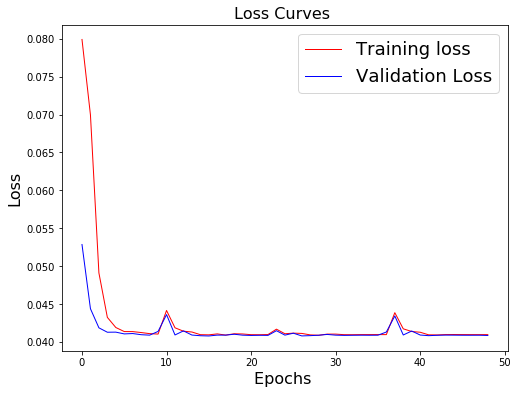

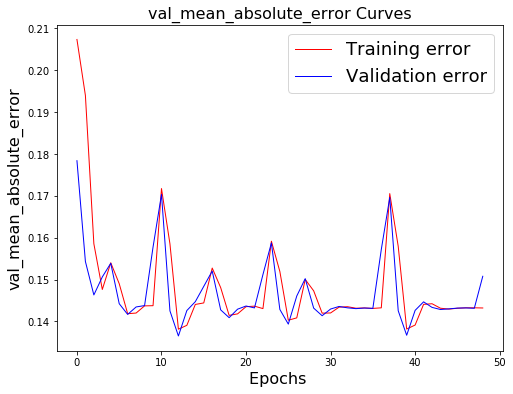

In [44]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

In [30]:
y_pred = model.predict_proba(X_test_bow, batch_size=batch_size, verbose=0)

/home/bangui/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


In [37]:
y_pred.max(), np.array(y_test_bow).max()

(0.5894008, 1.0)

In [33]:
y_test_bow[:10]

[0.16666666666666666, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 0.0]